In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from linear_models import ftr_transform, max_ftr_transform

# load results

In [86]:
wave = "db5"
dirs = [wave + "_saliency_warmstart_seed=1"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/adaptive-wavelets/notebooks/biology/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave=wave, mode='zero', J=4, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [87]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)

index2o = {}
index2t = {}
num = 0
for i, _ in enumerate(lamL1wave_grid):
    for j, _ in enumerate(lamL1attr_grid):
        loc = (lamL1wave == lamL1wave_grid[i]) & (lamL1attr == lamL1attr_grid[j])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            index2o[(i,j)] = loc
            index2t[num] = (i,j)
        num += 1
            
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)
psi_list = []
wt_list = []
for r in range(R):
    for c in range(C):
        wt = mos[index2o[(r,c)]]
        wt_list.append(wt)
        phi, psi, x = get_wavefun(wt)
        psi_list.append(psi)            

# compression

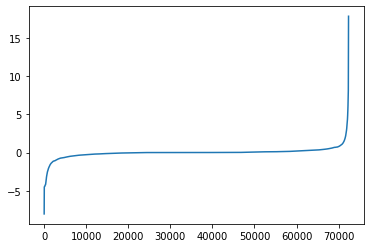

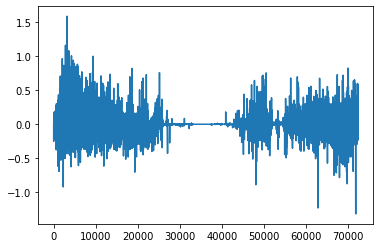

In [94]:
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

(train_loader, test_loader) = get_dataloader(p.data_path, 
                             batch_size=p.batch_size,
                             is_continuous=False)   

model = load_pretrained_model(p.model_path, device=device)  

# define trim model
mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

reps = torch.tensor([]).to(device)
attr = torch.tensor([]).to(device)

for data, _ in test_loader:
    data = data.to(device)
    data_t = wt(data)
    with torch.backends.cudnn.flags(enabled=False):
        attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
    y, _ = tuple_to_tensor(data_t)
    reps = torch.cat((reps, y), dim=0)     
    z, _ = tuple_to_tensor(attributions)
    attr = torch.cat((attr, z), dim=0)
reps = reps.reshape(-1)
attr = attr.reshape(-1)    

sort_indexes = torch.argsort(reps, dim=0, descending=False)    

plt.plot(reps[sort_indexes].detach().cpu())
plt.show()

plt.plot(attr[sort_indexes].detach().cpu())
plt.show()

In [89]:
1.0*(abs(reps) > 1e-3).sum() / reps.shape[0]

tensor(0.7752, device='cuda:0')

In [90]:
1.0*((abs(reps) < 1e3) & (abs(attr) > 1e-2)).sum() / reps.shape[0]

tensor(0.3292, device='cuda:0')

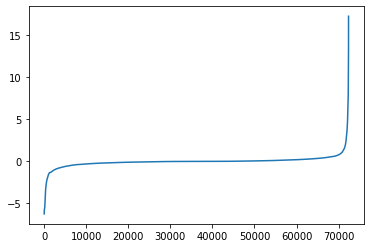

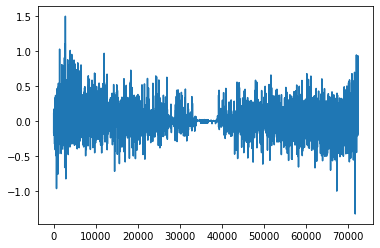

In [91]:
# define wavelet
wt_o = DWT1d(wave=res['wave'][0], mode='zero', J=res['J'][0], init_factor=1, noise_factor=0).to(device)

# define trim model
mt = TrimModel(model, wt_o.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='Saliency', device='cuda')

reps = torch.tensor([]).to(device)
attr = torch.tensor([]).to(device)

for data, _ in test_loader:
    data = data.to(device)
    data_t = wt_o(data)
    with torch.backends.cudnn.flags(enabled=False):
        attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
    y, _ = tuple_to_tensor(data_t)
    reps = torch.cat((reps, y), dim=0)     
    z, _ = tuple_to_tensor(attributions)
    attr = torch.cat((attr, z), dim=0)
reps = reps.reshape(-1)
attr = attr.reshape(-1)    

sort_indexes = torch.argsort(reps, dim=0, descending=False)    

plt.plot(reps[sort_indexes].detach().cpu())
plt.show()

plt.plot(attr[sort_indexes].detach().cpu())
plt.show()

In [92]:
1.0*(abs(reps) > 1e-3).sum() / reps.shape[0]

tensor(0.9083, device='cuda:0')

In [93]:
1.0*((abs(reps) < 1e3) & (abs(attr) > 1e-2)).sum() / reps.shape[0]

tensor(0.4127, device='cuda:0')